<a href="https://colab.research.google.com/github/yexf308/AppliedStatistics/blob/main/Ensemble_Methods_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from scipy.special import softmax

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

# Boosted Tree Model
Boosted Tree algorithms like AdaBoost and is also a Boosting algorithm.  Boosted Tree are also constructed based on the following two points:

- Training Method: Forward Stepwise Algorithm. The current tree is adjusted and trained based on the results of the previous trees, to improve accuracy.  Boosted Tree Model, which can be represented as follows:


$$
f_M(x)=\sum_{i=1}^MT(x,w_m)
$$  

Here, $T(x,w_m)$ represents a decision tree, $w_m$ is the parameter of the decision tree, and $M$ is the number of trees.

The forward Stepwise algorithm for training can be described as follows:

-  Assume the initial Tree is $f_0(x)=0$.

-  For $m=1,2,...,M$:
   - $$f_m(x)=f_{m-1}(x)+T(x,w_m) $$  
   Here, $f_{m-1}(x)$ represents the model that has been trained in the previous round. The current round's training objective is to obtain the optimal parameters of the current decision tree by minimizing a certain loss function

   - $$w_m^*=\arg\min_{w_m}\sum_{i=1}^m L(y_i,f_{m-1}(x_i)+T(x_i,w_m))$$  

- The final boosted tree becomes $f_M(x)=\sum_{i=1}^MT(x,w_m^*) $. 


In terms of the process, we can see the biggest difference between Boosted Trees and AdaBoost:

- AdaBoost focuses on misclassified points, and the next round's objective is more inclined to correct the misclassified points.

- Boosted Trees focus on the difference between the current model and the target. The training objective of the next round's model is to reduce the difference between the model and the target.


the biggest difference in Boosted Trees for different problems lies in the loss function. Next, we will briefly introduce regression Boosted trees with squared loss and classification Boosted trees with exponential loss:






# Boosted Regression Tree

If we choose square loss, then

$$
L(y_i,f(x_i))=\frac{1}{2}(y_i-f(x_i))^2
$$  

At $m$-step, the loss function is  

$$
L(y_i,f_{m-1}(x_i))=\frac{1}{2}[y_i-f_{m-1}(x_i)-T(x_i,w_m)]^2
$$  
As both $y_i$ and $f_{m-1}(x_i)$ are known, the optimal parameter $w_m$ that makes the following equation hold is: 
$$
T(x_i,w_m)=y_i-f_{m-1}(x_i)
$$  

Therefore, for the training of step $m$, we only need to use the residual $y-f_{m-1}(x)$ as the target $y$ for the model $T(x,w_m)$.

If we have a more general loss function? For example, if the loss function of a regression tree is absolute value, i.e., $L(y,f(x))=\mid y-f(x)\mid$, how should we update it? Obviously, the update target is no longer the residual. In fact, the solution is already in use, which is the negative gradient of the loss function with respect to the model:

$$
-\frac{\partial L(y,f(x))}{\partial f(x)}
$$   
This special case mentioned above is  essentially using the gradient descent method:


$$
-\frac{\partial\frac{1}{2}(y-f(x))^2}{\partial f(x)}=y-f(x)
$$  

Here are four possible choices of losses. 

- Square loss: $L(y_i,f_{m-1}(x_i))=\frac{1}{2}(f_{m-1}(x)-y)^2$ and its negative gradient is $y-f_{m-1}(x)$.

- Absolute loss: $L(y_i,f_{m-1}(x_i))=\mid f_{m-1}(x)-y \mid$ and its negative gradient is $\text{sign}(y-f_{m-1}(x))$.

- Huber loss: 
$L(y_i,f_{m-1}(x_i))=\left\{\begin{matrix}
\frac{1}{2}(f_{m-1}(x)-y)^2 & \mid y-f_{m-1}(x) \mid < \delta\\
\delta \mid y-f_{m-1}(x) \mid & \text{otherwise}
\end{matrix}\right.$
and its negative gradient is 
$\left\{\begin{matrix}
y-f_{m-1}(x) & \mid y-f_{m-1}(x) \mid < \delta\\
\delta\cdot \text{sign}(y-f_{m-1}(x)) & \text{otherwise}
\end{matrix}\right.$

- Quantile Loss: $L(y_i,f_{m-1}(x_i))= \left\{\begin{matrix}
\theta\mid y-f_{m-1}(x)\mid &  y>f_{m-1}(x)\\
(1-\theta)\mid y-f_{m-1}(x)\mid  & \text{otherwise}
\end{matrix}\right.$
and its negative gradient is 
$\left\{\begin{matrix}
\theta &  y>f_{m-1}(x)\\
\theta-1  & \text{otherwise}
\end{matrix}\right.$ where $0<\theta< 1$.


## Pro and Con
- The squared error amplifies errors that are larger than 1, making it more sensitive to outliers.

- The absolute error can avoid this problem, but it may cross the minimum point due to a large gradient near the minimum point.

- Huber loss and quantile loss mainly avoid the influence of outliers.


<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/translate0.png?raw=true" width="800" />

In [ ]:
class GradientBoostingRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0, loss='ls', huber_threshold=1e-1,
                 quantile_threshold=0.5):
        """
        :param base_estimator: For base learners, heterogeneity is allowed. 
                               For heterogeneity, a list of estimators is passed, such as [estimator1, estimator2, ..., estimator10], 
                               and n_estimators will be ignored in this case.
                               For homogeneity, a single estimator will be copied n_estimators times.
        :param n_estimators: 
        :param learning_rate: Reduce the weight of subsequent base learners to avoid overfitting 
        :param loss:loss function ls: square loss,
                                  lae: absolute loss, 
                                  huber: huber loss, 
                                  quantile: quantile loss.
        :param huber_threshold:    huber loss threshold，only when loss=huber
        :param quantile_threshold: quantile loss threshold，only when loss=quantile
        """
        self.base_estimator = base_estimator
        self.n_estimators   = n_estimators
        self.learning_rate  = learning_rate
        if self.base_estimator is None:
          self.base_estimator = DecisionTreeRegressor(max_depth=2)

        if type(base_estimator) != list:
          estimator = self.base_estimator
          self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        else:
          self.n_estimators = len(self.base_estimator)

        self.loss = loss
        self.huber_threshold = huber_threshold
        self.quantile_threshold = quantile_threshold

    def _get_gradient(self, y, y_pred):
        if self.loss == 'ls':
            return y - y_pred
        elif self.loss == 'lae':
            return (y - y_pred > 0).astype(int) * 2 - 1
        elif self.loss == 'huber':
            return np.where(np.abs(y - y_pred) > self.huber_threshold,
                            self.huber_threshold * ((y - y_pred > 0).astype(int) * 2 - 1), y - y_pred)
        elif self.loss == "quantile":
            return np.where(y - y_pred > 0, self.quantile_threshold, self.quantile_threshold-1)   


    def fit(self, x, y):
        # fit first base learner
        self.base_estimator[0].fit(x, y)
        y_pred = self.base_estimator[0].predict(x)
        new_y = self._get_gradient(y, y_pred)
        for index in range(1, self.n_estimators):
            # fit the rest base learners
            self.base_estimator[index].fit(x, new_y)
            y_pred += self.base_estimator[index].predict(x) * self.learning_rate
            new_y = self._get_gradient(y, y_pred)   

    def predict(self, x):
        return np.sum(
            [self.base_estimator[0].predict(x)] +
            [self.learning_rate * self.base_estimator[i].predict(x) for i in
             range(1, self.n_estimators - 1)] +
            [self.base_estimator[self.n_estimators - 1].predict(x)]
            , axis=0)              


In [ ]:
data = np.linspace(1, 10, num=100)
target1 = 3*data[:50] + np.random.random(size=50)*3# add noise
target2 = 3*data[50:] + np.random.random(size=50)*10# add noise 
target=np.concatenate([target1,target2])
data = data.reshape((-1, 1))

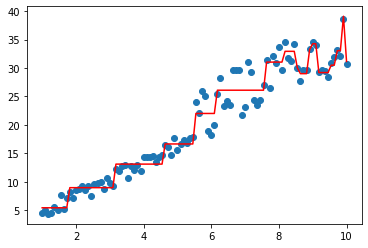

In [ ]:
model=GradientBoostingRegressor(base_estimator= DecisionTreeRegressor(max_depth=3), n_estimators=3)
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()

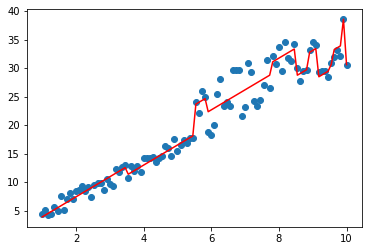

In [ ]:
model=GradientBoostingRegressor(base_estimator=[LinearRegression(), DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=3)])
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')

# Boosted Classification Tree
Classification can also be done using regression trees. In simple terms, several sets of regression trees, equal to the number of categories, are trained. Each set represents a category, and the outputs of all sets are transformed into a probability distribution using a softmax operation. Then, the negative gradient of each tree is calculated using a loss function such as cross-entropy or KL divergence, and used to guide the next round of training. For example, in a three-category classification, the process is as follows:

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/translate.png?raw=true" width="800" />

## Softmax + CrossEntropy and their gradient
For classification problems, cross-entropy is generally chosen as the loss function. Note $y$ is the one-hot expression of the label, so $\sum_{i=1}^n y_i=1$.

\begin{align}
&\text{softmax}([\hat{y}_1,\hat{y}_2,...,\hat{y}_n])=\frac{1}{\sum_{i=1}^n e^{\hat y_i}}[e^{\hat y_1},e^{\hat y_2},...,e^{\hat y_n}] \\
& \text{cross entropy}(y,p)=-\sum_{i=1}^n y_i\log p_i
\end{align}
Then the loss function is 
\begin{align}
L(\hat y,y)=-\sum_{i=1}^n y_i\log \frac{e^{\hat y_i}}{\sum_{j=1}^n e^{\hat y_j}}\\
=-\sum_{i=1}^n y_i(\hat y_i-\log\sum_{j=1}^n e^{\hat y_j})\\
=\log\sum_{i=1}^n e^{\hat y_i}-\sum_{i=1}^ny_i\hat y_i
\end{align}

To calculate the gradient: 
\begin{align}
\frac{\partial L(\hat y,y)}{\partial \hat y}=\text{softmax}([\hat y_1,\hat y_2,...,\hat y_n])-[y_1,y_2,...,y_n]
\end{align}

Then the fitting targets of the first set of regression trees are  $y_1-\frac{e^{\hat y_1}}{\sum_{i=1}^n e^{\hat y_i}}$, 
the fitting targets of the second set of regression trees are $y_2-\frac{e^{\hat y_2}}{\sum_{i=1}^n e^{\hat y_i}}$, ..., and the fitting targets of the $n$th set of regression trees are $y_n-\frac{e^{\hat y_n}}{\sum_{i=1}^n e^{\hat y_i}}$

In [ ]:
class GradientBoostingClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0):
        """
        :param base_estimator: For base learners, heterogeneity is allowed. 
                               For heterogeneity, a list of estimators is passed, such as [estimator1, estimator2, ..., estimator10], 
                               and n_estimators will be ignored in this case.
                               For homogeneity, a single estimator will be copied n_estimators times.
        :param n_estimators: 
        :param learning_rate: Reduce the weight of subsequent base learners to avoid overfitting.
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 
            self.base_estimator = DecisionTreeClassifier(max_depth=2)
        
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
      
        else:
            self.n_estimators = len(self.base_estimator)

        
        self.expand_base_estimators = []

    def fit(self, x, y):
        # turn y into one-hot encoding
        class_num = np.amax(y) + 1
        y_cate = np.zeros(shape=(len(y), class_num))
        y_cate[np.arange(len(y)), y] = 1

        # expand base estimator
        self.expand_base_estimators = [copy.deepcopy(self.base_estimator) for _ in range(class_num)]

        # fit the first model
        y_pred_score_ = []

        for class_index in range(0, class_num):
            self.expand_base_estimators[class_index][0].fit(x, y_cate[:, class_index])
            y_pred_score_.append(self.expand_base_estimators[class_index][0].predict(x))
        y_pred_score_ = np.c_[y_pred_score_].T
        # calculate the negative gradient
        new_y = y_cate - softmax(y_pred_score_)
        # train the subsequent models
        for index in range(1, self.n_estimators):
            y_pred_score = []
            for class_index in range(0, class_num):
                self.expand_base_estimators[class_index][index].fit(x, new_y[:, class_index])
                y_pred_score.append(self.expand_base_estimators[class_index][index].predict(x))
            y_pred_score_ += np.c_[y_pred_score].T * self.learning_rate
            new_y = y_cate - softmax(y_pred_score_)

    def predict_proba(self, x):
       
        y_pred_score = []
        for class_index in range(0, len(self.expand_base_estimators)):
            estimator_of_index = self.expand_base_estimators[class_index]
            y_pred_score.append(
                np.sum(
                    [estimator_of_index[0].predict(x)] +
                    [self.learning_rate * estimator_of_index[i].predict(x) for i in
                     range(1, self.n_estimators - 1)] +
                    [estimator_of_index[self.n_estimators - 1].predict(x)]
                    , axis=0)
            )
        return softmax(np.c_[y_pred_score].T)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [ ]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

In [ ]:
def plot_decision_function(X, y, clf, support_vectors=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
   
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=80, c='none', alpha=0.7, edgecolor='red')



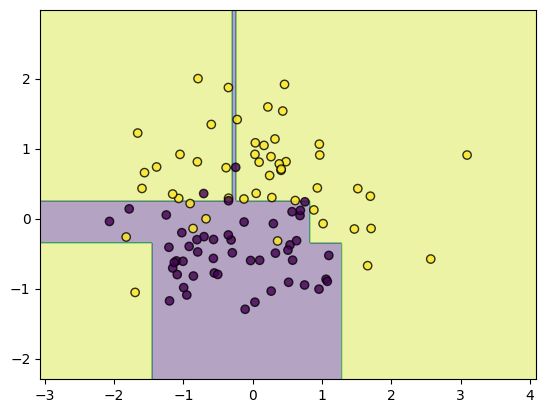

In [ ]:
classifier = GradientBoostingClassifier(base_estimator=DecisionTreeRegressor(max_depth=4),n_estimators=5)
classifier.fit(data, target)
plot_decision_function(data, target, classifier)

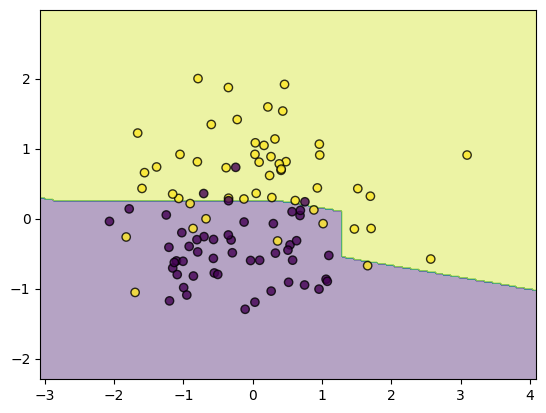

In [ ]:
classifier = GradientBoostingClassifier(base_estimator=[LinearRegression(),LinearRegression(),LinearRegression(),DecisionTreeRegressor(max_depth=2)])
classifier.fit(data, target)
plot_decision_function(data, target, classifier)

$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$